In [1]:
import os
os.chdir('..')
from isak.grapher import *

### Isak Andersson - AI23

## <p style="text-align:center;">Group Project - Deep Learning</p>
# <p style="text-align:center;">Face Keypoint Detection</p>

##### *With **Asajad Hussein Abdul-Kadhom** and **Mikael Folkesson***
---

## 1. Introduction

As a group, we researched different approaches to teaching a neural net how to recognize eyes, nose and mouth in an image of a face and to then use the model to find these keypoints in a completely new image of a face. This project rapport aims to show our process and what results we found along the way, and some of the lessons learned. In short, in many cases there's no need to reinvent the wheel, but one needs to recognize how the wheel is built before asking it to carry the cart. What I mean by this is that relying on coding LLMs often bite you, even if it first gave you a great starting of point, and did a lot of the research for you initially.

The assignment was short and intensive, for better and for worse. We each started attacking the problem from our own personal directions, but met up almost daily to sync up. And lastly applied our combined research into a working data pipeline and model.

In the end, Github user [nalbert9](https://github.com/nalbert9/Facial-Keypoint-Detection/) supplied the best working model structure for our use case, and we edited it according to our data needs. I would also like to credit [Horst Possegger](https://scholar.google.com/citations?user=iWPrl3wAAAAJ&hl=en) and the [Graz University of Technology](https://www.uni-graz.at/en/) for supplying us with the AFLW dataset.

## 2. Method

beskriv hur vi hittade modeller eller inspiration till modeller. beskriv hårdvara och optimeringsbekymmer. beskriv vilken som till slut fungerade bäst.

The dataset used is called [AFLW (Annotated Facial Landmarks in the Wild)](https://paperswithcode.com/dataset/aflw) and contains around 25,000 faces with varying number of annotations per image and face, and the images originally comes from the social media platform Flickr. The annotations used in this project were limited by scope and were as follows:
- Left eye, pupil (x, y)
- Right eye, pupil (x, y)
- Nose-tip (x, y)
- Mouth (center) (x, y)
- Face bounding box (x, y)
- Face bounding box (width, height)

AFLW also supplies more annotations such as additional keypoints, ethnicity, pose and sex, but these were left out based on a guessed performance limit that would mirror the length of the assignment.

### 2.1 Data processing

Although the data from AFLW came very well structured, there is some big gaps and NaN values. The decision was made to completely disregard any image that didn't have a full set of annotations of the annotations mentioned above. This, and the before mentioned missing annotations, left around 12,000 images.

Please see /data_pipeline.ipynb for all code surrounding the choice of images to use.

All remaining images where transformed in the following ways (utils.py -> gpu_transform()):
- Resized into 224x224 pixels and rearrange dimensions to fit our model.
- Normalize RGB values into values between 0 and 1.
- Adopt the ImageNet normalization mean and standard deviation.

<details>

<summary>gpu_transform()</summary>

```
def gpu_transform(image, device):
    image = torch.tensor(np.array(image)).permute(2, 0, 1).to(device).float() / 255.0
    image = torch.nn.functional.interpolate(image.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    image = (image - mean) / std
    return image
```

</details>

The reasoning behind these transformations came from experience, except the ImageNet values. Those values are credited to ImageNet and was found using a coding LLM.

### 2.2 Model structures

The best working model structure was taken from nalbert9 on github. However, nalbert9 was using many more keypoints and no bounding box which required some minor changes.

The tested model structures are as follows:

<details>
<summary>nalbert9 (fixed output features, no bounding box)</summary>

```
nalbert_Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=8, bias=True) # out_features is changed to 8 (2(x,y)) from 136 (68(x,y)).
  (drop1): Dropout(p=0.25, inplace=False)
)
```

</details>

<details>
<summary>nalbert9 (fixed output features, with bounding box)</summary>

```
nalbert_Net_wBbox(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_keypoints): Linear(in_features=512, out_features=8, bias=True)
  (fc_bbox): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.25, inplace=False)
)
```

</details>

<details>
<summary>experiment with batch normalization (with bounding box)</summary>

```
Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc_keypoints): Linear(in_features=512, out_features=8, bias=True)
  (fc_bbox): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)
```

</details>

### 2.3 Hardware and optimization

All computers used to run these networks had access to different kind of CUDA accelerated hardware, and this ran combined with PyTorch as the main framework. As presented in gpu_transform(), the .to(device) sent data to VRAM. This transform method was one of the optimizations made, and almost halved the runtime of 50 epochs by itself when compared to doing the transformations on the cpu.

Other optimizations included batch size variations in torch.DataLoader within the train/test split function (utils.py). There was also some experimentation with the "num_workers=" kwarg in the DataLoader class, but was ultimately left alone due to the Windows Blue Screen issues it brought.

## Analysis

Här kommer graferna och ordbajset kring det

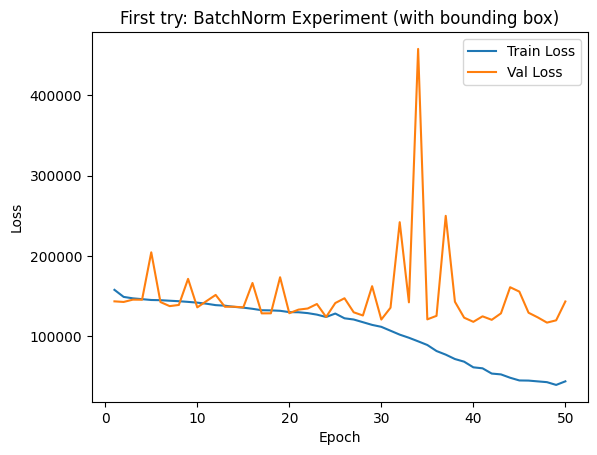

In [7]:
e, l, v = extract_data('isak/first50')

plot_loss(e,l,v, title='First try: BatchNorm Experiment (with bounding box)')

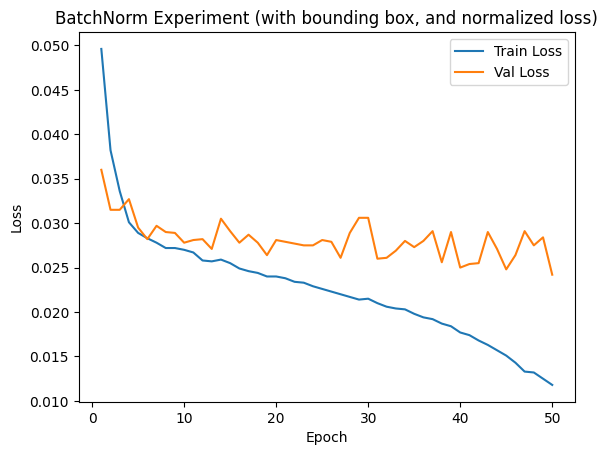

In [4]:
e, l, v = extract_data('isak/second50')

plot_loss(e,l,v, title='BatchNorm Experiment (with bounding box, and normalized loss)')

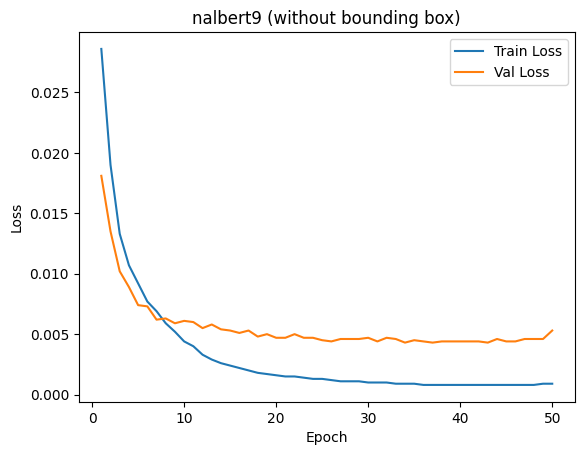

In [5]:
e, l, v = extract_data('isak/third50')

plot_loss(e,l,v, title='nalbert9 (without bounding box)')

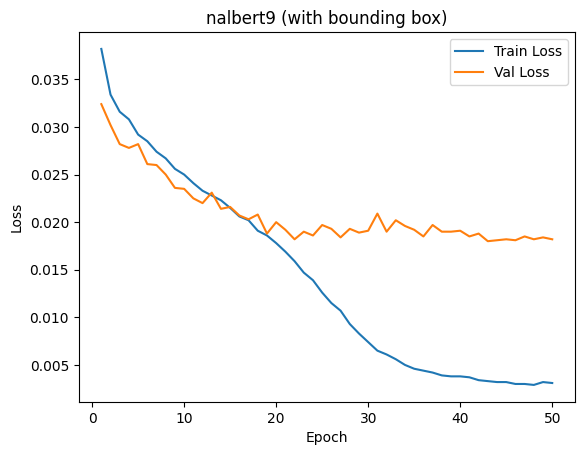

In [6]:
e, l, v = extract_data('isak/fourth50')

plot_loss(e,l,v, title='nalbert9 (with bounding box)')

## Summary

Varför blev det som det blev? Vad hade du gjort annorlunda om du fick 3 veckor till?

## Tools etc

Kanske beskriv hjälpmedel här, eller under *Method*